In [815]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import talib as ta
from talib import abstract
import yfinance as yfin
from arch import arch_model

pd.set_option('display.float_format', '{:.2f}'.format)


In [816]:
# data_path = '/Users/xinc./Documents/GitHub/Quant_idea/data/0804 大社課 TXF 1m.csv'
# df = pd.read_csv(data_path)
# df.index = pd.to_datetime(df['datetime'])
# df = df.drop(columns = ['Unnamed: 0', 'datetime', 'Date', 'Time'])
# df.columns = ['open', 'high', 'low', 'close', 'volume']

df = yfin.download('^TWII', start = '2024-6-1', end = '2024-7-31')
df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
# 計算資料DataFrame
ret_df = pd.DataFrame(index = df.index)
# 績效DataFrame
equity = pd.DataFrame()


[*********************100%%**********************]  1 of 1 completed


In [817]:
# parameters
data = df['close']
a = 0.9
# 0是perplexity的，1更平滑，2是網路
switch = 2
num_vol = 1
df['llt_slope'] = np.nan

def llt(data, a):
    llt = np.zeros(len(data))
    llt[0] = data[0]
    llt[1] = (1 - a) * data[0] + a * data[1]
    for n in range(2, len(data)):
        if switch == 0:
            llt[n] = (a ** 2 * llt[n - 1]) + (((1 - a) ** 2) * (data[n] - data[n - 1]))
        elif switch == 1:
            llt[n] = (1-a) ** 2 * data[n] + 2 * a * (1 - a) * llt[n - 1] - a ** 2 * llt[n - 2]    
        elif switch == 2:
            llt[n] = ((a - (a ** 2)/4) * data[n]) + (((a ** 2)/2) * data[n - 1]) - ((a - (3 * (a ** 2))/4) * data[n - 2]) + ((2 * (1 - a)) * llt[n - 1]) - (((1 - a) ** 2) * llt[n - 2])
    return llt

df['llt'] = llt(data, a)

for i in range(1, len(df)):
    df['llt_slope'][i] = df['llt'][i] - df['llt'][i - 1]

def bolinger_band(data, num_vol):
    model = arch_model(df['llt'].dropna(), vol = 'Garch', p = 1, q = 1)
    garch_fit = model.fit(disp = 'off')
    df['garch_volitility'] = garch_fit.conditional_volatility

    df['bolinger_upper'] = df['llt'] + num_vol * df['garch_volitility']
    df['bolinger_lower'] = df['llt'] - num_vol * df['garch_volitility']

    return df

df = bolinger_band(data, num_vol)

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/1425848899.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  llt[0] = data[0]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/1425848899.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  llt[1] = (1 - a) * data[0] + a * data[1]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/1425848899.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

In [818]:
df

,open,high,low,close,adj_close,volume,llt_slope,llt,garch_volitility,bolinger_upper,bolinger_lower
Date,,,,,,,,,,,
2024-06-03,21388.71,21612.54,21372.08,21536.76,21536.76,4756500,NaN,21536.76,882.78,22419.54,20653.98
2024-06-04,21513.85,21529.98,21308.97,21356.62,21356.62,4858900,-162.13,21374.63,1292.01,22666.64,20082.62
2024-06-05,21385.00,21510.86,21264.63,21484.88,21484.88,4124900,20.56,21395.19,1472.18,22867.37,19923.01
2024-06-06,21856.13,21970.63,21847.68,21902.70,21902.70,4777500,401.80,21796.99,1480.85,23277.84,20316.14
2024-06-07,21823.62,21920.85,21823.62,21858.38,21858.38,4981400,180.94,21977.93,1173.40,23151.33,20804.54
2024-06-11,21984.42,22003.71,21792.12,21792.12,21792.12,5291900,-154.21,21823.72,983.09,22806.82,20840.63
2024-06-12,21841.81,22094.94,21841.81,22048.96,22048.96,4372000,132.62,21956.35,1071.64,23027.99,20884.71
2024-06-13,22217.64,22440.10,22211.08,22312.04,22312.04,4207100,334.97,22291.31,981.98,23273.30,21309.33
2024-06-14,22311.93,22504.72,22252.02,22504.72,22504.72,4357100,231.48,22522.80,723.02,23245.82,21799.78


In [819]:
'''long only'''

'long only'

In [820]:
BS = None
fund = 1000000
feePaid = 600
ret_df['position'] = 0
ret_df['buy_price'] = 0
ret_df['sell_price'] = 0
ret_df['buy'] = 0
ret_df['sell'] = 0
ret_df['profit_list'] = np.zeros(len(df))
ret_df['profit_fee_list'] = np.zeros(len(df))
ret_df['profit_fee_list_realized'] = np.zeros(len(df))
cost_list = []

for i in range(2, len(df)):
    if i == len(df) - 1:
        break
    
    entryLong = df['llt_slope'][i] > 0
    exitShort = df['llt_slope'][i] < 0

    if BS == None:
        if entryLong:
            BS = 'B'
            t = i + 1
            ret_df['buy'].iloc[t] = t
            ret_df['buy_price'].iloc[t] = df['open'].iloc[t]
            ret_df['position'].iloc[t] += 1
            print(f"Buy signal at index {t}, buy price: {df['open'].iloc[t]}")
    elif BS == 'B':
        ret_df['position'].iloc[i + 1] = ret_df['position'].iloc[i]
        profit = 200 *(df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
        ret_df['profit_list'].iloc[i + 1] = profit

        if exitShort or i == len(df) - 2:
            pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t])
            profit_fee = profit - feePaid * 2
            ret_df['profit_fee_list'].iloc[i + 1] = profit_fee
            ret_df['sell_price'].iloc[i + 1] = df['open'].iloc[i + 1]
            ret_df['sell'].iloc[i + 1] = i + 1

            BS = None
            print(f"Sell signal at index {i+1}, sell price: {df['open'].iloc[i + 1]}, profit: {pl_round - feePaid * 2}")

            ret_df['profit_fee_list_realized'].iloc[i + 1] = pl_round - feePaid * 2

        else:
            profit_fee = profit
            ret_df['profit_fee_list'].iloc[i + 1] = profit_fee

df['strategy_ret'] = ret_df['profit_list'].cumsum()
equity['profitfee'] = ret_df['profit_fee_list_realized'].cumsum()

Buy signal at index 3, buy price: 21856.130859375
Sell signal at index 6, sell price: 21841.810546875, profit: -4064.0625
Buy signal at index 7, buy price: 22217.640625
Sell signal at index 14, sell price: 23124.310546875, profit: 180133.984375
Buy signal at index 17, buy price: 22859.9296875
Sell signal at index 21, sell price: 23009.8203125, profit: 28778.125
Buy signal at index 22, buy price: 23360.880859375
Sell signal at index 29, sell price: 23927.91015625, profit: 112205.859375
Buy signal at index 31, buy price: 23827.26953125
Sell signal at index 32, sell price: 23373.009765625, profit: -92051.953125
Buy signal at index 36, buy price: 22206.9296875
Sell signal at index 37, sell price: 22321.369140625, profit: 21687.890625


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/1870835680.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entryLong = df['llt_slope'][i] > 0
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/1870835680.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exitShort = df['llt_slope'][i] < 0
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/1870835680.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become

In [821]:
ret_df['index_ret'] = np.zeros(len(df))

for i in range(1, len(df)):
    ret_df['index_ret'].iloc[i] = (df['open'].iloc[i] - df['open'].iloc[i - 1]) * 200

ret_df['cum_index_ret'] = ret_df['index_ret'].cumsum()

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/3050492744.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ret_df['index_ret'].iloc[i] = (df['open'].iloc[i] - df['open'].iloc[i - 1]) * 200
/var/folders/0j/sdf7gd116kd5lv1

In [822]:
# 績效

In [823]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(ret_df[ret_df['buy'] > 0]) + len(ret_df[ret_df['sell'] >  0])
winRate = len([i for i in ret_df['profit_fee_list_realized'] if i > 0]) / len(ret_df['profit_fee_list_realized'])
profitFactor = sum([i for i in ret_df['profit_fee_list_realized'] if i>0]) / abs(sum([i for i in ret_df['profit_fee_list_realized'] if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

Profit :  246689.84375
Return :  0.24668984375000003
Max DrawDown :  0.06989232003957702
Caimar Ratio :  3.529570110282649
Trade Times :  12
Win Rate :  0.10256410256410256
Profit Factor :  3.566584165457597


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/710291725.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


In [824]:
(10861.01 - 10771.09) * 200

17984.000000000015

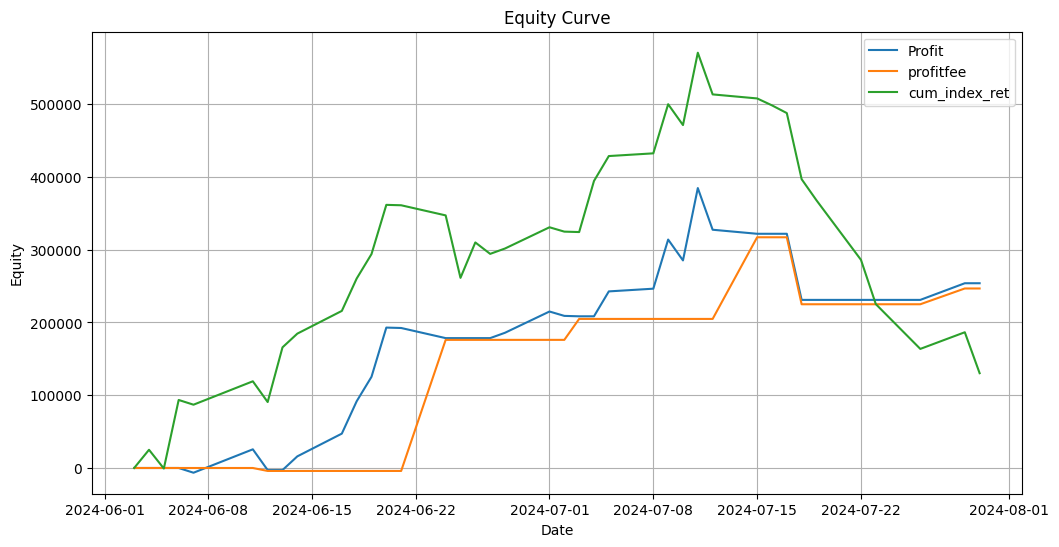

In [825]:
# 绘图
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['strategy_ret'], label='Profit')
ax.plot(df.index, equity['profitfee'], label='profitfee')
ax.plot(df.index, ret_df['cum_index_ret'], label='cum_index_ret')

# 设置纵轴刻度格式
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

# 添加网格、标签和标题
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Equity')
ax.set_title('Equity Curve')
ax.legend()

plt.show()


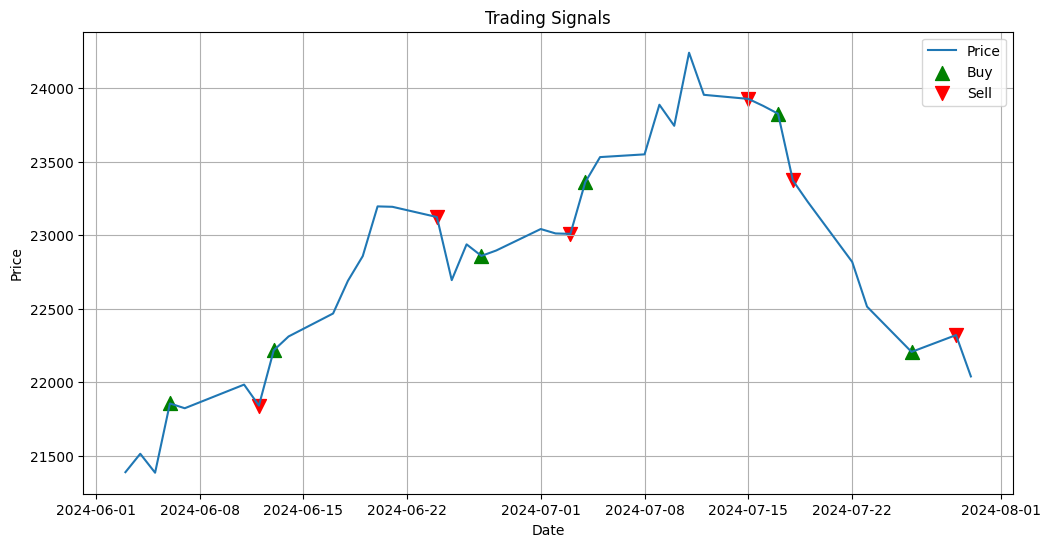

In [826]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['open'], label='Price')

# 标记买入点
buy_signals = ret_df[ret_df['buy'] != 0]
plt.scatter(buy_signals.index, buy_signals['buy_price'], marker='^', color='g', label='Buy', s=100)

# 标记卖出点
sell_signals = ret_df[ret_df['sell'] != 0]
plt.scatter(sell_signals.index, sell_signals['sell_price'], marker='v', color='r', label='Sell', s=100)

# 添加图例和标题
plt.legend()
plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [827]:
tdf = pd.DataFrame()
tdf['open'] = df['open']
tdf['buy_price'] = ret_df['buy_price']
tdf['sell_price'] = ret_df['sell_price']
tdf['profit_list'] = ret_df['profit_list']
tdf['position'] = ret_df['position']
tdf[:20]

,open,buy_price,sell_price,profit_list,position
Date,,,,,
2024-06-03,21388.71,0.00,0.00,0.00,0
2024-06-04,21513.85,0.00,0.00,0.00,0
2024-06-05,21385.00,0.00,0.00,0.00,0
2024-06-06,21856.13,21856.13,0.00,0.00,1
2024-06-07,21823.62,0.00,0.00,-6502.34,1
2024-06-11,21984.42,0.00,0.00,32160.16,1
2024-06-12,21841.81,0.00,21841.81,-28521.88,1
2024-06-13,22217.64,22217.64,0.00,0.00,1
2024-06-14,22311.93,0.00,0.00,18857.81,1


<Axes: xlabel='Date'>

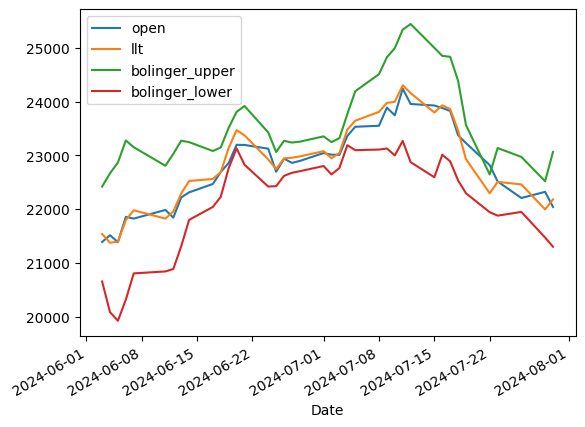

In [828]:
df[['open', 'llt', 'bolinger_upper', 'bolinger_lower']].plot()